In [1]:
#Import Libraries

In [2]:
!pip install shap

In [3]:

import tensorflow as tf
# tf.compat.v1.disable_v2_behavior()
# 
import statsmodels as sm
import pandas as pd
import numpy as np
import sklearn as skl
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_percentage_error as MAPE

import shap


In [4]:
def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

In [5]:
path_ds1 = "Krafthack2022/input_dataset-1.csv"
path_ds2 = "Krafthack2022/input_dataset-2.csv"
path_pred = "Krafthack2022/prediction.csv"

In [6]:
ds2 = pd.read_csv(path_ds2)

In [7]:
ds1 = pd.read_csv(path_ds1)

In [8]:
pred_old = pd.read_csv(path_pred)

In [9]:
print(ds1.columns)
print(ds2.columns)
print(pred_old.columns)

Index(['timepoints', 'Unit_4_Power', 'Unit_4_Reactive Power',
       'Turbine_Guide Vane Opening', 'Turbine_Rotational Speed',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Bolt_1_Steel tmp', 'Bolt_1_Torsion', 'Bolt_1_Tensile',
       'Bolt_2_Torsion', 'Bolt_2_Tensile', 'Bolt_3_Torsion', 'Bolt_3_Tensile',
       'Bolt_4_Torsion', 'Bolt_4_Tensile', 'Bolt_5_Torsion', 'Bolt_5_Tensile',
       'Bolt_6_Torsion', 'Bolt_6_Tensile', 'mode'],
      dtype='object')
Index(['timepoints', 'Unit_4_Power', 'Unit_4_Reactive Power',
       'Turbine_Guide Vane Opening', 'Turbine_Pressure Drafttube',
       'Turbine_Pressure Spiral Casing', 'Turbine_Rotational Speed', 'mode',
       'Bolt_1_Steel tmp', 'Bolt_1_Tensile', 'Bolt_2_Tensile',
       'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile',
       'Bolt_1_Torsion', 'Bolt_2_Torsion', 'Bolt_3_Torsion', 'Bolt_4_Torsion',
       'Bolt_5_Torsion', 'Bolt_6_Torsion', 'lower_bearing_vib_vrt',
       'turb

In [10]:
print("Min: " + min(ds1.timepoints))
print("Max: " + max(ds1.timepoints))

print("DS2")
print("Min: " + min(ds2.timepoints))
print("Max: " + max(ds2.timepoints))

print("Predict")
print("Min: " + min(pred_old.timepoints))
print("Max: " + max(pred_old.timepoints))

Min: 1970-06-24 09:48:36
Max: 1970-11-28 11:59:58
DS2
Min: 1970-12-19 09:51:44
Max: 1971-01-25 11:06:48
Predict
Min: 1971-01-25 11:06:49
Max: 1971-02-03 20:16:23


In [11]:
print("Ds1: " + str(len(ds1)))
print("Ds2: " + str(len(ds2)))
print("Full: " + str(len(ds1)+len(ds2)))

Ds1: 8607446
Ds2: 1874087
Full: 10481533


In [12]:
frames = [ds1, ds2]
# full_df = pd.concat(frames).sample(100000)
full_df = pd.concat(frames)

#### Dealing with NaN values
In order to keep it simple we simply discarded rows of data with NaN values.

An alternative approach would be to use for example K-nearest neighbors, with the sklearn
KNNImputer, in this case you would ideally make a train/validation set for this specific purpose in order to choose n_neighbors. In order to avoid data leakage imputing should only be done on a training set,
so it shouldn't solve NaN problems in the hold-out set.

In [13]:


full_df = full_df.dropna()

# imputer = KNNImputer(n_neighbors=2)
# imputer.fit_transform(X)


In [14]:
print("Full: " + str(len(full_df)))

Full: 943931


In [15]:
full_df["timepoints"] = pd.to_datetime(full_df["timepoints"], format='%Y-%m-%d %H:%M:%S') 

In [16]:
copy_df = full_df.copy()

In [17]:
copy_df.index = copy_df.timepoints
copy_df = copy_df.drop("timepoints", axis=1)

In [18]:
copy_df = copy_df.sort_index()

copy_df['seconds'] = copy_df.index - copy_df.index[0]

copy_df['seconds'] = copy_df['seconds'].dt.total_seconds()

copy_df.head()

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Rotational Speed,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Bolt_1_Steel tmp,Bolt_1_Torsion,Bolt_1_Tensile,Bolt_2_Torsion,...,Bolt_4_Torsion,Bolt_4_Tensile,Bolt_5_Torsion,Bolt_5_Tensile,Bolt_6_Torsion,Bolt_6_Tensile,mode,lower_bearing_vib_vrt,turbine_bearing_vib_vrt,seconds
timepoints,,,,,,,,,,,,,,,,,,,,,
1970-12-29 10:59:57,311.093257,4.949223,94.206187,108.033198,150.827828,5305.873472,2.458908,177.730733,1609.140569,163.324591,...,226.013417,1603.236155,298.403158,1637.373796,161.914265,1678.107726,operation,0.154292,0.517703,0.0
1970-12-29 10:59:58,311.103996,5.051777,94.206457,108.033197,150.774664,5305.690188,2.458729,177.736039,1609.127944,163.323607,...,226.013106,1603.235101,298.403272,1637.353554,161.912569,1678.100380,operation,0.155838,0.530280,1.0
1970-12-29 10:59:59,311.114735,5.154330,94.206726,108.033196,150.559452,5305.466701,2.459334,177.735616,1609.138758,163.328645,...,226.013736,1603.236408,298.397846,1637.360655,161.912716,1678.106863,operation,0.169547,0.540085,2.0
1970-12-29 11:00:00,311.125475,5.256883,94.206995,108.033195,150.344239,5305.243213,2.459329,177.738552,1609.121478,163.331201,...,226.017247,1603.230738,298.400658,1637.365372,161.912572,1678.078172,operation,0.173561,0.526994,3.0
1970-12-29 11:00:01,311.136214,5.359436,94.207264,108.033194,150.129027,5305.019725,2.459337,177.741082,1609.113766,163.329769,...,226.013418,1603.246668,298.402517,1637.354723,161.915946,1678.067193,operation,0.166955,0.524617,4.0


In [19]:
x_cols = list(pred_old.drop("timepoints", axis=1).columns)
x_cols.append("seconds")

In [20]:
#Y columns
y_cols = [c for c in copy_df.columns if "Tensile" in c]
Y_df = copy_df[y_cols]

print(Y_df.shape)
Y_df.dropna()

#X columns
X_df = copy_df[x_cols]

(943931, 6)


In [21]:
#Cleaning up dataset

In [22]:
# plt.figure(figsize=(10,7))
# figure=sns.heatmap(X_df.corr(), annot=True)

In [23]:
#Dropping column: Unit_4_Power
X_df = X_df.drop("Turbine_Guide Vane Opening",axis=1)

In [24]:
print(str(max(X_df.seconds)/(60*60*24)))

27.004756944444445


In [25]:
X_df["day"] = X_df.index.day
X_df["weekday"] = X_df.index.weekday
X_df["month"] = X_df.index.month
X_df["hour"] = X_df.index.hour

X_df_ = X_df.copy()

In [26]:
X_df = pd.get_dummies(X_df_, columns=["mode"], drop_first=True)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, shuffle=True) # 0.25 x 0.8 = 0.2

cols_scale = [c for c in X_train.columns if c != 'mode_start']
print(cols_scale)
scaler = MinMaxScaler()
scaler.fit(X_train.loc[:, cols_scale])


X_train.loc[:, cols_scale] = scaler.transform(X_train.loc[:, cols_scale])
X_test.loc[:, cols_scale] = scaler.transform(X_test.loc[:, cols_scale])
X_val.loc[:, cols_scale] = scaler.transform(X_val.loc[:, cols_scale])


['Unit_4_Power', 'Unit_4_Reactive Power', 'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing', 'Turbine_Rotational Speed', 'seconds', 'day', 'weekday', 'month', 'hour']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [149]:
class NN_Model():
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
        self.X_test, self.y_test = X_test, y_test
        
        self.model = None
        self.pred_model = None
        
        self.features_num = self.X_train.shape[1]
        self.targets_num = self.y_train.shape[1]
        
    def make_nn_model(self, layers=None,
                      activation='relu', drop_rate=0.2, drop_rate_inference=False):
        
        if not drop_rate_inference:
            self.layers, self.activation = layers, activation
            dropout = Dropout
        else:
            layers, activation = self.layers, self.activation
            #Using dropout during prediction for uncertainty
            dropout = MCDropout
            
        inputs = Input(shape=(self.features_num,))
        for i, lay in enumerate(layers):
            if i == 0:
                x = Dense(lay, activation='relu')(inputs)
#                 x = BatchNormalization()(x)
                x = dropout(drop_rate)(x)
            else:
                x = Dense(lay, activation='relu')(x)
#                 x = BatchNormalization()(x)
                x = dropout(drop_rate)(x)
        outputs = Dense(self.targets_num, activation='linear')(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Evens_lille_venn")
        if not drop_rate_inference:
#             model.summary()
            self.model = model
        else:
            return model
        
    def for_tune(self, layers, activation, drop_rate, lr, epochs=4000, patience=10, batch_size=32, verbose=0):
        tf.keras.backend.clear_session()
        self.make_nn_model(layers, activation, drop_rate)
        self.fitting(lr=lr, batch_size=batch_size, epochs=epochs, patience=patience, verbose=verbose)
        
        y_pred = self.model.predict(X_val)
        
        return y_pred
        
    
    def fitting(self, epochs=1000, patience=100, batch_size=32, lr=0.00001, verbose=1, save_path=None):
        if self.model is not None:
            self.epochs, self.patience, self.batch_size, self.lr = epochs, patience, batch_size, lr
            es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
            optimizer = tf.keras.optimizers.Adam(lr=lr)
            self.model.compile(optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
            # Prepare the training dataset
            train_dataset = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train))
            train_dataset = train_dataset.shuffle(buffer_size=4096).batch(batch_size)

            # Prepare the validation dataset
            val_dataset = tf.data.Dataset.from_tensor_slices((self.X_val, self.y_val))
            val_dataset = val_dataset.batch(batch_size)
            self.history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[es_callback], verbose=verbose)
            if save_path is not None:
                self.model.save_weights(save_path)
            return self.model, self.history
        
    def fit_on_all(self, epochs=1000, patience=100, batch_size=32, lr=0.00001, verbose=1, save_path=None):
        if self.model is not None:
            self.epochs, self.patience, self.batch_size, self.lr = epochs, patience, batch_size, lr
            es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
            optimizer = tf.keras.optimizers.Adam(lr=lr)
            self.model.compile(optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
            # Prepare the training dataset
            X_train = pd.concat([X_train, X_test])
            y_train = pd.concat([y_train, y_test])
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
            train_dataset = train_dataset.shuffle(buffer_size=4096).batch(batch_size)

            # Prepare the validation dataset
            val_dataset = tf.data.Dataset.from_tensor_slices((self.X_val, self.y_val))
            val_dataset = val_dataset.batch(batch_size)
            self.history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[es_callback], verbose=verbose)
            if save_path is not None:
                self.model.save_weights(save_path)
            return self.model, self.history        
        
    def load_model(self, path):
        self.model.load_weights(path)
    
    def dropout_model(self, drop_rate_predict=0.2):
        self.model_dropout = self.make_nn_model(drop_rate = drop_rate_predict, drop_rate_inference=True)
        self.model_dropout.set_weights(self.model.get_weights())
        return self.model_dropout
        
    def loss_plot(self):
        hist = self.history.history
        fig, ax = plt.subplots(figsize=(10, 15))
        ax.plot(np.arange(len(hist['val_loss'])), hist['val_loss'], label='val_loss')
        ax.plot(np.arange(len(hist['val_loss'])), hist['loss'], label='loss')
        plt.legend()

In [150]:
def dropout_predict(model, X, y, credible_interval=0.95, iterations=100):
    if iterations < 2:
        iterations = 2
    predictions = np.zeros((y.shape[0], y.shape[1], iterations))
    for i in range(iterations):
        pred = model.predict(X)
        print(pred)
        predictions[:, :, i] = pred
    y_pred = np.mean(predictions, axis=2)
    lower = np.quantile(predictions, 0.5-credible_interval/2, axis=2)
    upper = np.quantile(predictions, 0.5+credible_interval/2, axis=2)
    
    return y_pred, lower, upper

In [151]:

def random_grid_tuner(save_path='test'):
    layers_ls = [[32, 32], [32, 32, 32], [32, 32, 32, 32], [64, 64, 64, 64], [128, 128, 128, 128]]
    lr_ls = [0.001, 0.0005, 0.0001, 0.00001]
    drop_rate_ls = [0.1, 0.2, 0.3, 0.4]
    activation_ls = ['relu', 'swish']
    batch_size_ls = [4096]

    grid = {'layers':layers_ls, 'lr':lr_ls, 'drop_rate':drop_rate_ls, 'activation':activation_ls, 'batch_size': batch_size_ls}

    ix_ls = []

    mape_best = 100
    rounds = 5
    np.random.seed(43)
    for i in range(rounds):
        print("")
        print("Round: ", i)
        round = 0
        while True:
            ixs = []
            use_vals = {}
            for key, val in grid.items():
                ix = np.random.randint(0, high=len(val))
                ixs.append(ix)
                use_vals[key] = val[ix]
            again = False
            for ix_in in ix_ls:
                if ixs == ix_in:
                    again = True
            if not again:
                break
            else:
                round += 1
            if round == 3:
                break
        print("Using params: ", use_vals)
        y_val_pred = nn.for_tune(**use_vals, verbose=2)
        mape = MAPE(y_val, y_val_pred)
        r2 = R2(y_val, y_val_pred)
        print("MAPE: ", mape)
        print("R2: ", r2)
        if mape < mape_best:
            mape_best = mape
            best_model = nn.model
            best_params = use_vals
            print("")
            print("***New Best***")
            print("Best params: ", best_params)
            print("Best MAPE: ", mape_best)
            print("Best r2: ", r2)

    print("mape_best", mape_best)
    print("best_params", best_params)
    best_model.save_weights(save_path)
    return best_model, mape_best


In [152]:
nn = NN_Model(X_train, y_train, X_val, y_val, X_test, y_test)
nn.make_nn_model(layers=[20, 20, 20], drop_rate=0.3, activation='relu')
# best_model, mape_best = random_grid_tuner()


In [33]:
# nn.model.save_weights('temp_model')

In [153]:
nn.load_model('uncertainty_model')

# nn.fitting(lr=0.00001, batch_size=32, epochs=5000, patience=30)

In [154]:
model_dropout = nn.dropout_model(drop_rate_predict=0.5)
y_pred, lower, upper = dropout_predict(model_dropout, X_test, y_test, iterations=20)

[[1537.6431  1481.7446  1668.0935  1637.6471  1680.2534  1675.8667 ]
 [1159.0172  1139.5638  1274.4807  1236.094   1277.7562  1271.3314 ]
 [ 776.56036  750.33154  852.17834  830.59814  853.3599   853.151  ]
 ...
 [1861.224   1827.8156  2038.2968  1997.3519  2080.2512  2045.7212 ]
 [1895.449   1847.8883  2069.1074  2024.0804  2066.9978  2078.4844 ]
 [1031.3889   993.8545  1111.4508  1085.9025  1123.9211  1126.0271 ]]
[[1798.251   1740.21    1945.1522  1917.1951  1939.9344  1958.0492 ]
 [1375.8398  1317.5718  1479.6934  1457.2063  1489.8647  1513.6064 ]
 [ 962.7166   908.5507  1036.1182  1006.96625 1036.0885  1063.3895 ]
 ...
 [1214.9048  1159.2766  1308.3036  1305.7466  1299.151   1322.2942 ]
 [ 541.266    533.2825   592.28986  586.9616   598.3781   598.7509 ]
 [1380.1882  1308.6932  1486.7993  1481.911   1476.7352  1508.7415 ]]
[[1872.0867  1802.1627  2016.4746  1974.3453  2010.7291  2030.5131 ]
 [1846.7296  1782.0563  1988.5211  1972.3816  1995.3812  1997.3353 ]
 [2013.4774  1951.9525

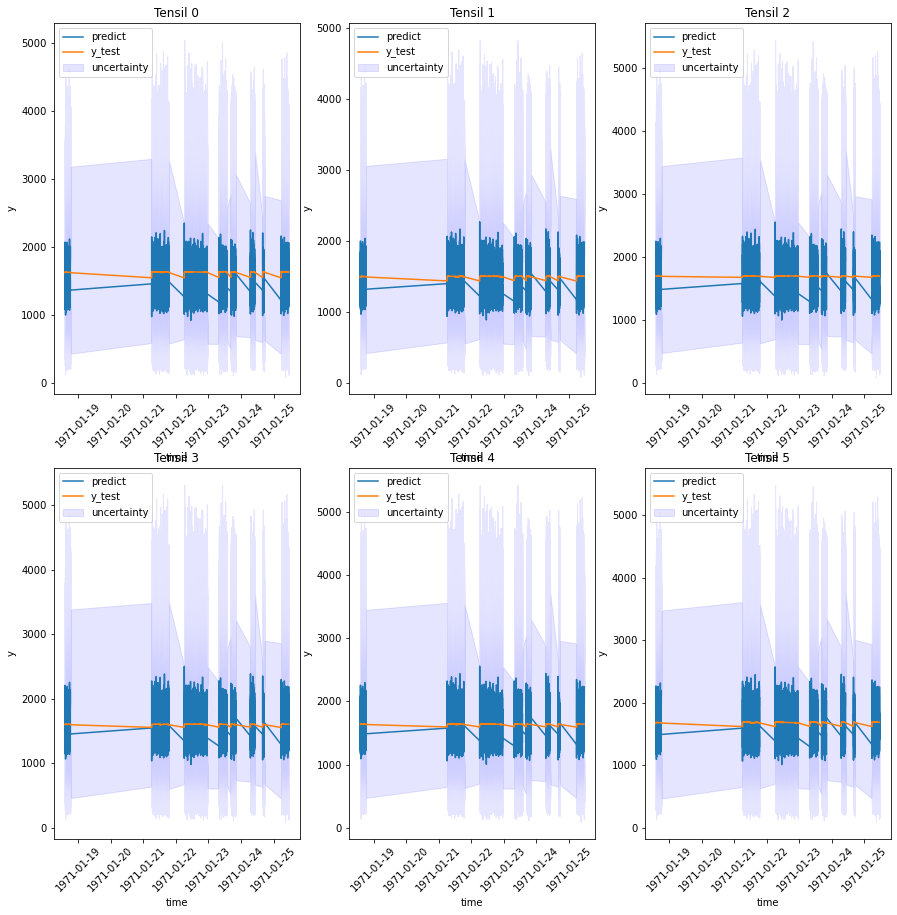

In [156]:


# y_test_sort = y_test.sort_index()
# X_test_sort = X_test.sort_index()
def scatter():
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        rmse = RMSE(y_test.iloc[:, i], y_pred[:, i])
        r2 = R2(y_test.iloc[:, i], y_pred[:, i])
        mape = MAPE(y_test.iloc[:, i], y_pred[:, i])
        ax.scatter(y_test.iloc[:, i], y_pred[:, i], label='r2: %s, mape %s' %(np.round(r2, 5), np.round(mape, 5)))
        ax.set_xlabel(r'y_test ($\mu m / m $)', fontsize=10)
        ax.set_ylabel(r'y_pred ($\mu m / m $)', fontsize=10)
        ax.set_title('Tensil %s' %(i))
        ax.legend(loc=2)
        
def time_plot():
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
#         rmse = RMSE(y_test.iloc[:, i], y_pred[:, i])
#         r2 = R2(y_test.iloc[:, i], y_pred[:, i])
        mape = MAPE(y_test.iloc[:, i], y_pred[:, i])
        ax.plot(y_test.iloc[:, i].index, y_pred[:, i], label='predict')
        ax.plot(y_test.iloc[:, i].index, y_test.iloc[:, i], label='y_test')
        ax.fill_between(y_test.iloc[:, i].index, lower[:, i], upper[:, i], color='b', alpha=.1, label='uncertainty')
        ax.set_xlabel('time', fontsize=10)
        ax.set_ylabel('y', fontsize=10)
        ax.set_title('Tensil %s' %(i))
        ax.tick_params(axis='x', labelrotation=45)
        ax.legend(loc=2)
# scatter()
time_plot()

In [38]:
# hist = history.history
# fig, ax = plt.subplots(figsize=(10, 15))
# ax.plot(np.arange(len(hist['val_loss'])), hist['val_loss'], label='val_loss')
# ax.plot(np.arange(len(hist['val_loss'])), hist['loss'], label='loss')
# plt.legend()

## YO

In [41]:
# import shap
# background = X_train.sample(1000)
background = shap.sample(X_train, 100)

# # DeepExplainer to explain predictions of the model
# explainer = shap.DeepExplainer(nn.model, background)
# # compute shap values
# shap_values = explainer.shap_values(X_test)

# shap_values.summary

explainer = shap.KernelExplainer(nn.model, background)


In [100]:
# shap_values = explainer(X_test.values)
use_vals = X_test.sample(2000)
shap_values = explainer.shap_values(use_vals)

  0%|          | 0/2000 [00:00<?, ?it/s]

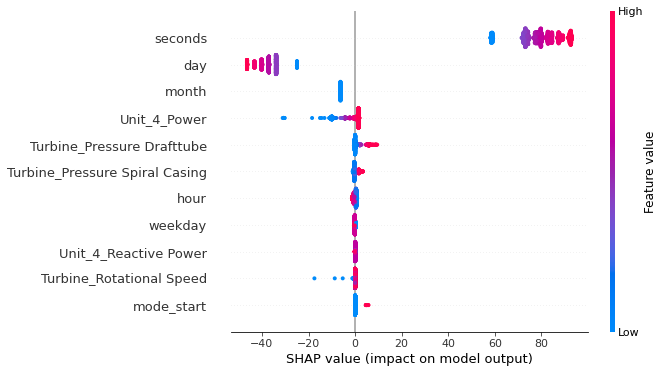

In [101]:
# X_test.columns

tur_ix = 0
shap.summary_plot(np.array(shap_values)[tur_ix, :, :], use_vals, plot_type='dot')

# shap_values_ = np.array(shap_values)


In [102]:
print(np.array(shap_values[0]).shape)
print(use_vals.shape)
use_vals.loc[:, cols_scale] = scaler.inverse_transform(use_vals.loc[:, cols_scale])

(2000, 11)
(2000, 11)


In [140]:
main_f = 'Unit_4_Power'
# main_f = 'hour'

int_index = "Turbine_Pressure Spiral Casing"

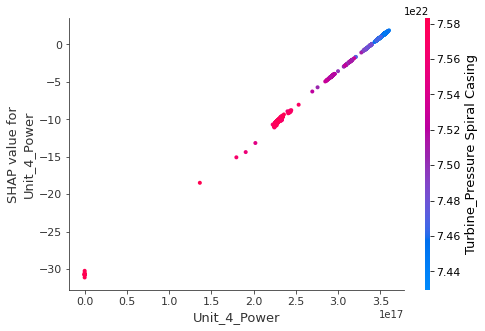

In [141]:

tur_ix = 0
shap.dependence_plot((main_f),
    np.array(shap_values)[tur_ix, :, :], use_vals.loc[:, ], interaction_index=int_index)

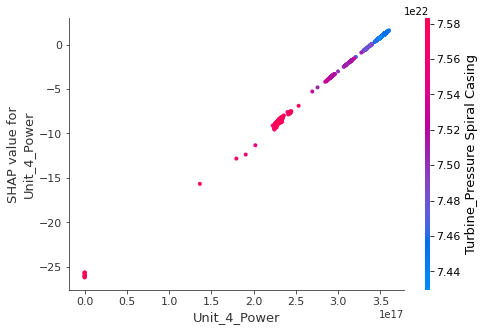

In [157]:
tur_ix = 1
shap.dependence_plot((main_f),
    np.array(shap_values)[tur_ix, :, :], use_vals.loc[:, ], interaction_index=int_index)

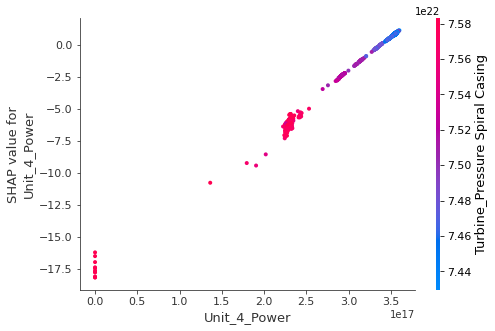

In [158]:
tur_ix = 2
shap.dependence_plot((main_f),
    np.array(shap_values)[tur_ix, :, :], use_vals.loc[:, ], interaction_index=int_index)

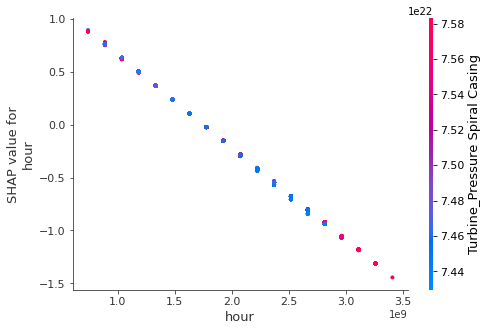

In [137]:
tur_ix = 3
shap.dependence_plot((main_f),
    np.array(shap_values)[tur_ix, :, :], use_vals.loc[:, ], interaction_index=int_index)

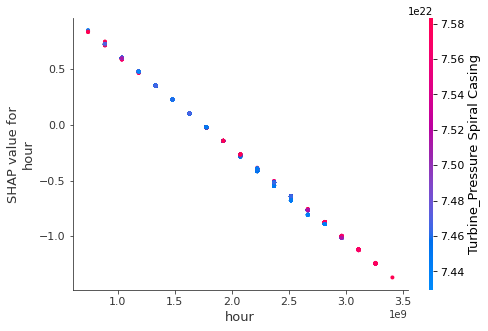

In [138]:
tur_ix = 4
shap.dependence_plot((main_f),
    np.array(shap_values)[tur_ix, :, :], use_vals.loc[:, ], interaction_index=int_index)

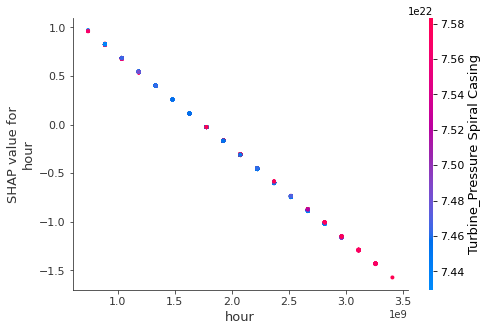

In [139]:
tur_ix = 5
shap.dependence_plot((main_f),
    np.array(shap_values)[tur_ix, :, :], use_vals.loc[:, ], interaction_index=int_index)